# A Statistical Study of High Frequency Crypto Reactions to FOMC Tone

Author : Thibault Charbonnier \
Date : November 2025 \
Contact : thibault.charbonnier@ensae.fr

---

## Table of contents

- [I. Introduction](#i-introduction)
  - [1. Context & Motivations](#1-context--motivations)
  - [2. Project Contributions](#2-project-contributions)
  - [3. Bibliography](#3-bibliography)

- [II. Dataset](#ii-dataset)
  - [1. Origin](#1-origin)
  - [2. Scraping & Data Acquisition](#2-scraping--data-acquisition)
  - [3. Limits](#3-limits)

- [III. Methodology](#iii-methodology)
  - [1. NLP Sentiment Scoring](#1-nlp-sentiment-scoring)
  - [2. HF Market Reactions](#2-hf-market-reactions)
  - [3. Data Pipeline](#3-data-pipeline)
  - [4. Tone Buckets Distributions](#4-tone-buckets-distributions)
  - [5. Testing Returns Explanations](#5-testing-returns-explanations)
  - [6. Exploring Temporal Response](#6-exploring-temporal-response)
  - [7. Cross-Crypto Diffusion](#7-cross-crypto-diffusion)

- [IV. Empirical Results](#iv-empirical-results)

- [V. Conclusion](#v-conclusion)

---

> ## Note on the project
>
> Building the data infrastructure (scrapers, parsers, event alignment, crypto return engine, nlp scoring) took a fair amount of work.  
> To make it reusable, I’m packaging it as a Python library published on PyPI.
>
> **Package :** `fomc-crypto-hf`  
> **Repo:** `...`

---

## I. Introduction

### 1. Context & Motivations

Monetary‐policy communication is one of the few scheduled macro events that reliably
reprice global risk in minutes. While a vast literature studies high-frequency
reactions of rates, FX and equities to FOMC statements/press conferences,
crypto remains an open laboratory: it trades 24/7, concentrates liquidity in a few
venues, and shows fast microstructure dynamics that are ideal for event studies. At
the same time, central-bank announcements bundle policy and information
components; recent research shows that tone and wording can shift prices even
absent a surprise rate move. This makes NLP a natural tool to extract a continuous
tone signal beyond labels (“hike/cut/hold”).

### 2. Projet Contributions

This project sits at the intersection of high-frequency monetary-policy identification, central-bank communication/NLP, and crypto event studies.

- **Reusable data infrastructure.** : Robust pipeline to download/parse FOMC texts, align high-frequency prices to event timestamps
- **Distributional analysis by tone buckets.** : Clear visuals and statistics to see where distributions differ—center vs. tails.  
- **Statistical tests for explainability.** : Small sample robust inference to quantify whether NLP features explain direction or amplitude of crypto returns.
- **Temporal response exploration.** : Local projections of cumulative returns across horizons to read speed/shape of adjustment

### 3. Bibliography

Here are a few related papers that inspired this work :

- **Kuttner (2001)** formalizes *surprise vs. expected* components around FOMC using futures.  
- **Gürkaynak, Sack & Swanson (2005)** show that announcements load on at least two factors—*target* (current rate) and *path* (future guidance)—so “actions vs. words” both matter.
- **Nakamura & Steinsson (2018)** argue that some price reactions reflect new macro information revealed by the Fed, not just the policy action.  
- **Jarociński & Karadi (2020)** formalize this separation using sign-restricted identification and multiple high-frequency instruments.  
- **Hansen & McMahon (2016)** (and follow-ups) document that central-bank communication—tone, topics—matters for markets and expectations.  
- Later work uses topic models or tone measures to quantify statements/press-conference content; this supports our simple, transparent tone score as a first pass. 
- **Corbet et al. (2020)** and follow-ups study crypto responses to macro/FOMC news; results vary by asset and period.  
- **Benigno & Rosa (2023)** highlight a “Bitcoin–macro disconnect” in some samples, consistent with our finding of weak **mean** predictability but meaningful **distributional/timing** patterns.

---

## II. Dataset

### 1. Origin

I do not use a prepackaged dataset, I built it. Two main data pillars:

**(A) FOMC communication**
- Statements: the short policy statement posted on the Fed’s website at the decision time (typically around 2:00 p.m.). We parse the full text from the website (https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm) to built a statement tone index with a NLP pipeline.
- Press-conference transcripts: Q&A (roughly ~30 minutes after the statement) transcript and prepared remarks. We treat this as an additional information release and compute a tone delta (press − statement).

**(B) Crypto prices**
- Minute-level bars for given cryptocurrencies on a regular grid around each event (\[-x, +y\] minutes).  
- Primary source: Binance historical archives (https://data.binance.vision)
- When symbols were not yet listed or data are incomplete, we use fallback venues (other major exchanges).


### 2. Scraping

**Fed pages**
- We automated retrieval of statement pages and press-conference transcripts directly from the Fed website.  
- The scraper follows the link structure of the archive pages; for each meeting it:
  1. Locates the statement (prefers PDF but falls back to HTML when PDF missing).  
  2. Locates the press-conference transcript (PDF first, then HTML).  
  3. Stores text in cache.
- Because the Fed’s site structure changes across years (pre-/post-2016), the module includes multiple patterns and fallback parsers.

**Crypto data**
- We fetch minute bars around each event window from Binance archives when available.  
- If the asset wasn’t listed yet or the archive is incomplete around the event time, we try fallback sources.
- All series are resampled to a regular minute grid.


### 3. Limits

- **Website heterogeneity over time**: older Fed pages use different layouts and link types (PDF vs HTML, changed paths).  
- **Timestamp reliability**: posted times vs effective times can differ (we used by default 2:00 p.m. and 2:30 p.m. to simplify)
- **Crypto coverage before listing**: for early years some minute data are missing/patchy.
- **Minute-bar quality**: early minutes after listing can be noisy
- **Small-n**: number of meetings is structurally limited


---

## III. Methodology

This section describes how I built the library, how text is turned into tone features, how market reactions are measured, and how we test distributional and predictive relationships in high-frequency setting.

### 1. Data pipeline

The first part of the project was dedicated to build the dataset from scrath including the following steps :

1. **Scrap & parse** Fed texts (Statements + press conference transcripts) : ingest this data properly by cleaning and chunking it.
2. **Analyse sentiment** by scoring texts chunks with a pre-trained LLM via Hugging Face
3. **Load prices** (Binance primary; Coinbase/Bitstamp fallback) : dowload and align high frequency data (minute grid).  
4. **Compute** returns for multiple horizons.
5. **Join** features and reactions

All steps write cache to save time when rerunning.

Here is a diagram of the data pipeline :

![Pipeline Schema](image/Pipeline%20schema.png)



### 2. NLP tone scoring

**Objects.** For each FOMC meeting we collect:
- `statement` (official text at decision time),  
- `press` (press-conference transcript, later on the same day).

**Scoring.** Each document is mapped to a tone score `score ∈ [0,10]` by a fixed NLP model (I used the specialized pre-trained model FOMC-RoBERTa https://huggingface.co/gtfintechlab/FOMC-RoBERTa but the architecture supports other, and possibly our own, LLM model).

**Handling long documents**  \
The text we analyse can be long (q&A in particular with +25 pages easily) so we use the following procedure :
- **Chunking**: chunk the original text in smaller parts of length `max_len` (512 tokens for FOMC-RoBERTa but the parameter is dynamically ajusted according to model selection).  
- **Pooling across chunks**: we perform a simple score mean across the chunks but one could think about a more sophisticated way to aggregate the score (add a weighting scheme for exemple).

**A few words about FOMC-RoBERTa** :

FOMC-RoBERTa is a domain-adapted and fine-tuned variant of RoBERTa trained specifically on Federal Reserve texts—FOMC statements, press-conference transcripts, minutes, and related speeches. We first run domain-adaptive pretraining : continue optimizing the masked-language modeling objective on this in-domain corpus so the encoder internalizes policy jargon (for example “forward guidance”, “balance sheet”). \

The base model RoBERTa itself is a Transformer encoder-only architecture (multi-head self-attention + feed-forward blocks) trained only with masked-language modeling next-sentence prediction. It uses byte-pair encoding tokenization, dynamic masking, large batches, and longer pretraining on massive corpora to learn strong bidirectional contextual representations.

Specific documentation :
- Hugging Face doc : https://huggingface.co/docs/transformers/en/model_doc/roberta
- Original academic paper for RoBERTa : https://arxiv.org/abs/1907.11692
- Domain-adaptive pretraining : https://aclanthology.org/2020.acl-main.740


### 3. High-frequency market reactions

**Price grid.** Minute bars (mid/WAP) on a fixed grid in \([-120, +120]\) minutes around the
**statement time \(t=0\)**; press time is stored separately.

**Abnormal & standardized returns.** We remove the minute-of-day drift and scale by pre-event
volatility from \([-120,-60]\) minutes:

\[
r^{abn}_{i,a,h}=r_{i,a,h}-\mathbb{E}[r\mid\text{minute-of-day}],\qquad
r^{std}_{i,a,h}=\frac{r^{abn}_{i,a,h}}{\widehat{\sigma}_{i,a,\text{pre}}}.
\]

Unless stated otherwise, analyses use \(r^{std}\) to reduce heteroskedasticity.
We winsorize 1–2% in robustness checks.

### 4. Tone-bucket distributions

We visualize and summarize the shape of returns conditional on tone.

- **Histograms + KDE** by bucket, with mean markers and sample sizes.
- **Moment skew** (Fisher, bias-corrected) and **quantile-based skew** (more robust to heavy tails):

\[
\text{Skew}_q(p)=\frac{Q_{1-p}+Q_p-2Q_{0.5}}{Q_{1-p}-Q_p}, \quad p\in\{0.10,0.15\}.
\]

- **Shift function (Δ-quantiles):** for \(\tau\in\{0.1,\dots,0.9\}\),
\[
\Delta Q_\tau=Q_\tau(\text{dovish})-Q_\tau(\text{hawkish}),
\]
with percentile bootstrap CIs. This shows *where* distributions differ (left tail / center / right tail).

Inference uses percentile **bootstrap** (small \(n\)); p-values are reported when relevant.


### 5. Testing whether tone explains returns

We test linear, directional, and tail‐risk relations. Standard errors are HC1 (heteroskedasticity-robust).

**Mean (linear) test**
\[
r^{std}_{h}=\alpha+\beta\, s+\varepsilon.
\]

**Direction (logit)**
\[
\Pr\!\left(r^{std}_{h}>0\right)=\text{logit}^{-1}\!\left(\alpha+\beta\, s\right),
\]
with hit-rate, Brier score, and AUC.

**Tail event (amplitude)**
\[
\Pr\!\left(\,|r^{std}_{h}|>x\,\right)=\text{logit}^{-1}\!\big(\alpha+\beta_1 s+\beta_2|s|+\beta_3\Delta s+\beta_4|\Delta s|\big),
\]
for thresholds \(x\) (e.g., 0.5–1.0σ or 25/50 bps on raw scale). Odds ratios and CIs are reported.

We also report a simple **signed-return** diagnostic, \(\mathbb{E}[r^{std}_h\cdot \operatorname{sign}(s)]\),
as a compact measure of directional alignment.


### 6. Temporal response (local projections)

To study **when** the reaction materializes, we cumulate returns and estimate one regression per horizon:

\[
CR_h=\sum_{t=0}^{h} r^{std}(t)=\alpha_h+\beta_h s+\varepsilon_h,\qquad h\in\{1,\dots,60\}\text{ min}.
\]

Plotting \(\beta_h\) with 95% CIs yields a response curve (peak time, persistence, fraction realized
in the first \(k\) minutes). This guides feasibility (HFT vs low-latency).


---

# 0. Basic setup

In [1]:
# Global imports
import pandas as pd
from src.ingestor.fomc_data import FOMCDownloader
from src.sentiment.nlp_pipeline import NLPPipeline
from src.market.market_processor import MarketProcessor
from src.tools.logging_config import setup_logging, get_logger
from src.utilities import load_cached_sentiments, print_event_reactions
from scripts.plot_sentiment import plot_fedfunds_aligned

# Logging system initialization
setup_logging()
logger = get_logger("notebook")

c:\Users\pcharbonnier\OneDrive - DVHE\Etudes\ENSAE 2025-2026\Cours\FOMC-NLP-Arbitrage-Diffusion\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Full Pipeline Execution

### 1.1 FOMC Events Scrapping

FOMC statements and press conference transcripts are already loaded in cache (data/_cache/fomc_data). \
Reruning the following cell is thus not mandatory to perform the other tasks.

Else: \
-> Scrapping running time ~ 1.20 min

In [ ]:
FOMCDownloader(start_year=2013,
               end_year=2016,
               sleep_sec=0.5).sync()

### 1.2 Sentiment analysis NLP Pipeline

The NLP Pipeline has already been run and the results are stored in cache (data/_cache/raw_sentiments). \
The cached results can be used with the argument "use_cache" set to True.

Else : \
-> Scoring running time ~ 1h40

In [14]:
nlp_pipe = NLPPipeline()
fomc_raw_events = nlp_pipe.run(use_cache=False)

2025-11-03 19:55:42 INFO  Pipeline run started
2025-11-03 19:55:42 INFO  Gathering statement and press conference files...
2025-11-03 19:55:43 INFO  Found 80 valid meetings with both statement & pressconf
2025-11-03 19:55:43 INFO  Found 80 date pairs to process
2025-11-03 19:55:43 INFO  Processing date 20130320
2025-11-03 19:55:44 INFO  	Scoring statement
2025-11-03 19:55:48 INFO  		Number of chunks : 2 | computed in 3.64 seconds
2025-11-03 19:55:48 INFO  	Scoring press conference
2025-11-03 19:56:30 INFO  		Number of chunks : 25 | computed in 41.88 seconds
2025-11-03 19:56:30 INFO  	Date processed: Statement score 0.01, PressConf score 3.76
2025-11-03 19:56:30 INFO  Processing date 20130619
2025-11-03 19:56:33 INFO  	Scoring statement
2025-11-03 19:56:37 INFO  		Number of chunks : 2 | computed in 3.96 seconds
2025-11-03 19:56:37 INFO  	Scoring press conference
2025-11-03 19:57:33 INFO  		Number of chunks : 25 | computed in 56.20 seconds
2025-11-03 19:57:33 INFO  	Date processed: State

### 1.3 Market Data Reactions

Maket Data (Raw format) has already been cached (data/_cache/market_data).\
To construct market reactions around FOMC run the following code with previously built fomc_raw_events. \
To used market cached data use the argument "force_fetch" set to False.

Else : \
-> Market Data downloading and reaction computation ~ ...

If you're not running the previous cell please execute this one to load cached sentiment data :

In [2]:
fomc_raw_events = load_cached_sentiments()

In [3]:
processor = MarketProcessor(symbols=["BTCUSDT"],
                            windows=[i for i in range(1, 61)],
                            pre_margin=0)
processor.process_events(events=fomc_raw_events,
                         save_computation=True,
                         force_fetch=False)

2025-11-04 15:52:22 INFO  Computing market reactions to FOMC events...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 20-03-2013 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 19-06-2013 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 18-09-2013 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 18-12-2013 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 19-03-2014 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 18-06-2014 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 17-09-2014 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 17-12-2014 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC event on 18-03-2015 for crypto BTCUSDT...
2025-11-04 15:52:22 INFO  Computing reactions for FOMC e

[FOMCEvent(meeting_date='20-03-2013', t_statement='14:00:00', t_pressconf='14:30:00', score_stmt=0.0094797611236572, score_qa=3.761565198898316, delta_score=3.7520854377746575, reactions={'BTCUSDT': 1      17.995915
 2      21.264423
 3      21.264423
 4      21.264423
 5      21.264423
 6      24.531863
 7      17.995915
 8      24.531863
 9      19.630302
 10     62.030888
 11    134.994325
 12    133.378685
 13    133.378685
 14    133.378685
 15     50.633020
 16     50.633020
 17     63.658095
 18     63.658095
 19     63.658095
 20     63.658095
 21           NaN
 22           NaN
 23           NaN
 24           NaN
 25           NaN
 26           NaN
 27           NaN
 28           NaN
 29           NaN
 30           NaN
 31           NaN
 32           NaN
 33           NaN
 34           NaN
 35           NaN
 36           NaN
 37           NaN
 38           NaN
 39           NaN
 40           NaN
 41           NaN
 42           NaN
 43           NaN
 44           NaN
 45       

In [4]:
print_event_reactions()

Meeting date on 29-07-2020:
NLP scoring for statement file : 3.317888259887696
NLP scoring for press conference transcript : 2.5870554129282635
{}
----------------------------------------
Meeting date on 18-09-2013:
NLP scoring for statement file : 2.6976518630981445
NLP scoring for press conference transcript : 1.557742804288864
{}
----------------------------------------
Meeting date on 13-12-2023:
NLP scoring for statement file : 6.619953950246175
NLP scoring for press conference transcript : 5.818973367864436
{}
----------------------------------------


# Statistical Study

### 0) Sanitary check

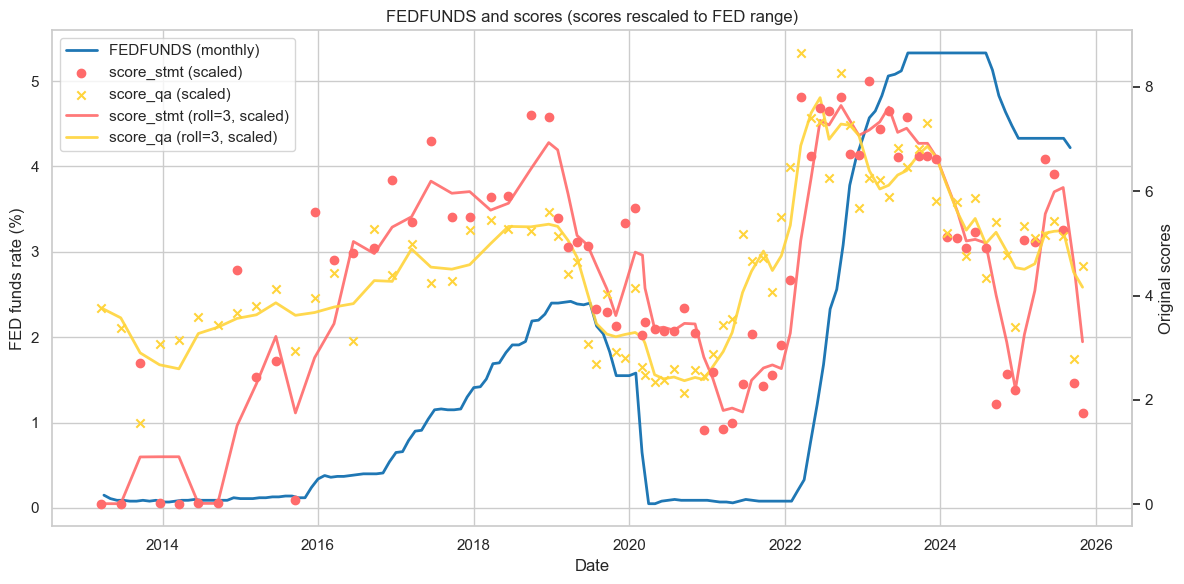

In [5]:
plot_fedfunds_aligned(df=pd.read_csv("data/_cache/full_sentiment/full_sentiment_cache.csv"),
                      fed_csv="data/rates/FEDFUNDS.csv",
                      outpath="outputs/Scores vs FedFunds Rate.png",
                      show_delta=False,
                      plot_mode='both',
                      ma_window=3)

=> Résultats cohérents : les scores ont l'air de coller aux vrais taux

### 1) Prepare the data

In [1]:
import pandas as pd
from src.quant_analysis.data_prep import add_tone_buckets
from src.quant_analysis.visualization import plot_bucket_distributions_by_window_wide

# Load data from cache
df = pd.read_csv("data/_cache/full_sentiment/full_sentiment_cache.csv")

# Add tone buckets based on score_stmt quantiles
df = add_tone_buckets(
    df=df,
    score_col="score_stmt",
    q=0.25,
    col_name="tone_bucket",
)
print(df.groupby("tone_bucket").size())

tone_bucket
dovish     20
hawkish    20
neutral    40
dtype: int64


### 2) Bucket distributions & Skewness

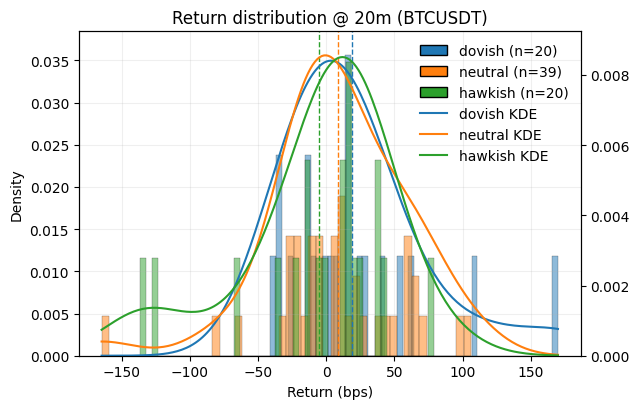

In [4]:
plot_bucket_distributions_by_window_wide(
    df=df,
    horizon_min=20,
    buckets=("dovish", "neutral", "hawkish"),
    bins=50,
    plot_kde=True
)

In [6]:
from src.quant_analysis.analysis import skew_bootstrap

skew_bootstrap(
    df, ret_col=f"BTCUSDT_20m", bucket_col="tone_bucket", cluster_col="meeting_date",
    bucket_A="dovish", bucket_B="hawkish", B=1000, random_state=42
)

Skew dovish: 1.5867,
Skew hawkish: -1.3338, 
Δ-skew: 2.9205, 
IC95%: [0.4377, 4.2699]


### 3) Returns explenation with the NLP scores 

In [2]:
from src.quant_analysis.analysis import run_regressions

summary = run_regressions(
    df,
    horizons_min=[10, 20, 30, 60],
    asset_prefix="BTCUSDT",
    score_col="score_stmt",
    center_value=5.0,
    scale=None,   # ou 5.0 pour normaliser sur ~[-1,1]
)
summary


Régression du score_stmt sur les rendements BTCUSDT à horizon 10 min :
  alpha = 7.1664 (p=0.2, IC95% [-3.7307, 18.0634])
  beta  = -10.4439 (p=0.15, IC95% [-24.7627, 3.8749])
  R² = 0.0823, n = 79, SE = HC1
------------------------------------------------------------------------
Régression du score_stmt sur les rendements BTCUSDT à horizon 20 min :
  alpha = 5.3820 (p=0.36, IC95% [-6.0818, 16.8459])
  beta  = -4.0413 (p=0.12, IC95% [-9.1429, 1.0602])
  R² = 0.0318, n = 79, SE = HC1
------------------------------------------------------------------------
Régression du score_stmt sur les rendements BTCUSDT à horizon 30 min :
  alpha = 1.7690 (p=0.8, IC95% [-11.6727, 15.2107])
  beta  = -1.2213 (p=0.76, IC95% [-9.1021, 6.6595])
  R² = 0.0020, n = 62, SE = HC1
------------------------------------------------------------------------
Régression du score_stmt sur les rendements BTCUSDT à horizon 60 min :
  alpha = -9.1116 (p=0.34, IC95% [-27.6819, 9.4587])
  beta  = -0.5075 (p=0.93, IC95% [-

,horizon_min,alpha,alpha_p,alpha_ci_low,alpha_ci_high,beta,beta_p,beta_ci_low,beta_ci_high,r2,n,se_type,target_col
0,10,7.166358,0.197415,-3.730721,18.063436,-10.443891,0.152841,-24.762668,3.874886,0.082310,79,HC1,BTCUSDT_10m
1,20,5.382034,0.357487,-6.081788,16.845857,-4.041334,0.120508,-9.142873,1.060204,0.031759,79,HC1,BTCUSDT_20m
2,30,1.769005,0.796451,-11.672687,15.210697,-1.221288,0.761328,-9.102056,6.659480,0.002031,62,HC1,BTCUSDT_30m
3,60,-9.111606,0.336216,-27.681863,9.458651,-0.507460,0.928602,-11.607501,10.592582,0.000180,62,HC1,BTCUSDT_60m


In [2]:
from src.quant_analysis.analysis import run_logit_over_horizons

summary = run_logit_over_horizons(
    df,
    horizons_min=[10, 20, 30, 60],
    asset_prefix="BTCUSDT",
    score_col="score_stmt",
    center_value=5.0,   # 0–10 -> [-5, +5]
    scale=None,         # ou 5.0 pour normaliser sur ~[-1,1]
)
summary


Régression logistique (signe) du score_stmt -> BTCUSDT à horizon 10 min :
  alpha = 0.3366 (p=0.15, IC95% [-0.1265, 0.7998])
  beta  = 0.0076 (p=0.94, IC95% [-0.1953, 0.2106])
  odds(beta) = 1.0077 (IC95% [0.8226, 1.2344])
  Hit-rate=0.5823, Brier=0.2432, AUC=0.4941, n=79, SE=HC1
------------------------------------------------------------------------
Régression logistique (signe) du score_stmt -> BTCUSDT à horizon 20 min :
  alpha = 0.3314 (p=0.16, IC95% [-0.1303, 0.7932])
  beta  = -0.0012 (p=0.99, IC95% [-0.1984, 0.1960])
  odds(beta) = 0.9988 (IC95% [0.8200, 1.2166])
  Hit-rate=0.5823, Brier=0.2432, AUC=0.4993, n=79, SE=HC1
------------------------------------------------------------------------
Régression logistique (signe) du score_stmt -> BTCUSDT à horizon 30 min :
  alpha = 0.3992 (p=0.13, IC95% [-0.1110, 0.9093])
  beta  = 0.0418 (p=0.75, IC95% [-0.2204, 0.3040])
  odds(beta) = 1.0427 (IC95% [0.8022, 1.3553])
  Hit-rate=0.5968, Brier=0.2403, AUC=0.5265, n=62, SE=HC1
----------

,horizon_min,alpha,alpha_p,alpha_ci_low,alpha_ci_high,beta,beta_p,beta_ci_low,beta_ci_high,odds_beta,odds_beta_ci_low,odds_beta_ci_high,hit_rate,brier,auc,n,se_type,target_col
0,10,0.336627,0.154287,-0.126520,0.799775,0.007638,0.941193,-0.195280,0.210555,1.007667,0.822604,1.234363,0.582278,0.243212,0.494071,79,HC1,BTCUSDT_10m
1,20,0.331434,0.159483,-0.130318,0.793187,-0.001196,0.990514,-0.198433,0.196040,0.998804,0.820015,1.216575,0.582278,0.243230,0.499341,79,HC1,BTCUSDT_20m
2,30,0.399160,0.125117,-0.110957,0.909276,0.041771,0.754876,-0.220449,0.303990,1.042655,0.802159,1.355255,0.596774,0.240261,0.526486,62,HC1,BTCUSDT_30m
3,60,-0.112803,0.661015,-0.616985,0.391379,0.116628,0.381052,-0.144328,0.377585,1.123702,0.865604,1.458758,0.516129,0.245926,0.563218,62,HC1,BTCUSDT_60m


In [4]:
from src.quant_analysis.analysis import tail_event_logit

print(tail_event_logit(df, "BTCUSDT_20m", "score_stmt", 100.0))

{'n': 79, 'beta': -0.3064037254691193, 'p_beta': 0.7877505303246404, 'odds': 0.7360893814280255, 'auc': 0.5296803652968036, 'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper object at 0x00000275A2C7DF90>}


In [2]:
from src.quant_analysis.analysis import logit_sign_extremes

print(logit_sign_extremes(df, "BTCUSDT_20m", "score_stmt"))

{'n': 32, 'beta': -0.056475457672207297, 'p_beta': 0.9186508582357825, 'odds': 0.9450896789112164, 'auc': 0.5, 'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper object at 0x000001EE9FEED6A0>}
